#### Date: Jun 2019 *(review in March 2024)*<br>Programmer: Christian Dittmar, Yiğitcan Özer
This is the demo script which illustrates the main functionalities of the 'NMF toolbox'. For a detailed description we refer to [1,2] (see References below).

#### The script proceeds in the following steps:
<br>1. It loads an target audio file containing the intro of the song "Let it be", by "The Beatles".
<br>2. It loads a source audio file containing the sound of buzzing bees in different pitches.
<br>3. It computes the STFT of all audio data.
<br>4. It applies the diagonal NMF as described in [1], in order to approximate the target with the timbral content of the source.
<br>5. It visualizes the NMF results.
<br>6. It resynthesizes the audio mosaic.

### Initialization

In [1]:
import os
import numpy as np
import soundfile as sf
import IPython.display as ipd

from libnmfd.core import nmf_diag
from libnmfd.dsp.algorithms import griffin_lim
from libnmfd.dsp.transforms import forward_stft
from libnmfd.utils import EPS, MAX_WAV_VALUE, make_monaural, pcm_int16_to_float32np
from libnmfd.utils.core_utils import visualize_components_nmf

In [2]:
INPUT_DIR = 'data'
OUT_DIR = 'output'

# create the output directory if it doesn't exist
if not os.path.isdir(OUT_DIR):
    os.makedirs(OUT_DIR)

filename_source = 'Bees_Buzzing.wav'
filename_target = 'Beatles_LetItBe.wav'

### 1. Load the source and target signal

In [3]:
# read signals
xs, fs = sf.read(file=os.path.join(INPUT_DIR, filename_source),dtype=np.float32)
xt, fs = sf.read(file=os.path.join(INPUT_DIR, filename_target),dtype=np.float32)

# make monaural if necessary
xs = make_monaural(xs)
xt = make_monaural(xt)


### 2. Compute STFT of both signals

In [4]:
BLOCK_SIZE = 2048
HOP_SIZE = 1024

# STFT computation
Xs, As, Ps = forward_stft(xs, block_size=BLOCK_SIZE, hop_size=HOP_SIZE, reconst_mirror=True, append_frames=True)
Xt, At, Pt = forward_stft(xt, block_size=BLOCK_SIZE, hop_size=HOP_SIZE, reconst_mirror=True, append_frames=True)

# get dimensions and time and freq resolutions
_, num_target_frames = Xt.shape
num_bins, num_source_frames = Xs.shape
time_res = HOP_SIZE / fs
freq_res = fs / BLOCK_SIZE

### 3. Apply continuity NMF variants to mosaicing pair

In [7]:
# initialize activations randomly
H0 = np.random.rand(num_source_frames, num_target_frames)

# init templates by source frames
W0 = As * 1./ (EPS + np.sum(As, axis=0))
Xs = Xs * 1./ (EPS + np.sum(As, axis=0))

# call the reference implementation as provided by Jonathan Driedger
nmfdiagW, nmfdiagH = nmf_diag(V=At, 
                              num_iter=30,
                              init_W=W0, 
                              init_H=H0, 
                              fix_W=True,
                              cont_polyphony=10,
                              cont_length=7,
                              cont_grid=5,
                              cont_sparsen= (1, 7))

# create mosaic, replacing the magnitude frames by complex valued frames
contY = Xs @ nmfdiagH

Processing:   0%|          | 0/30 [00:00<?, ?it/s]

(1025, 431)
(0,)


IndexError: index 0 is out of bounds for axis 0 with size 0

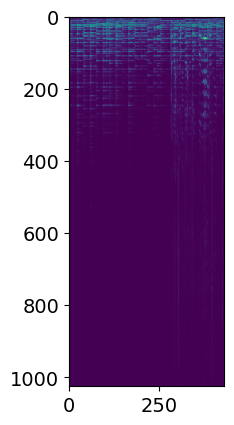

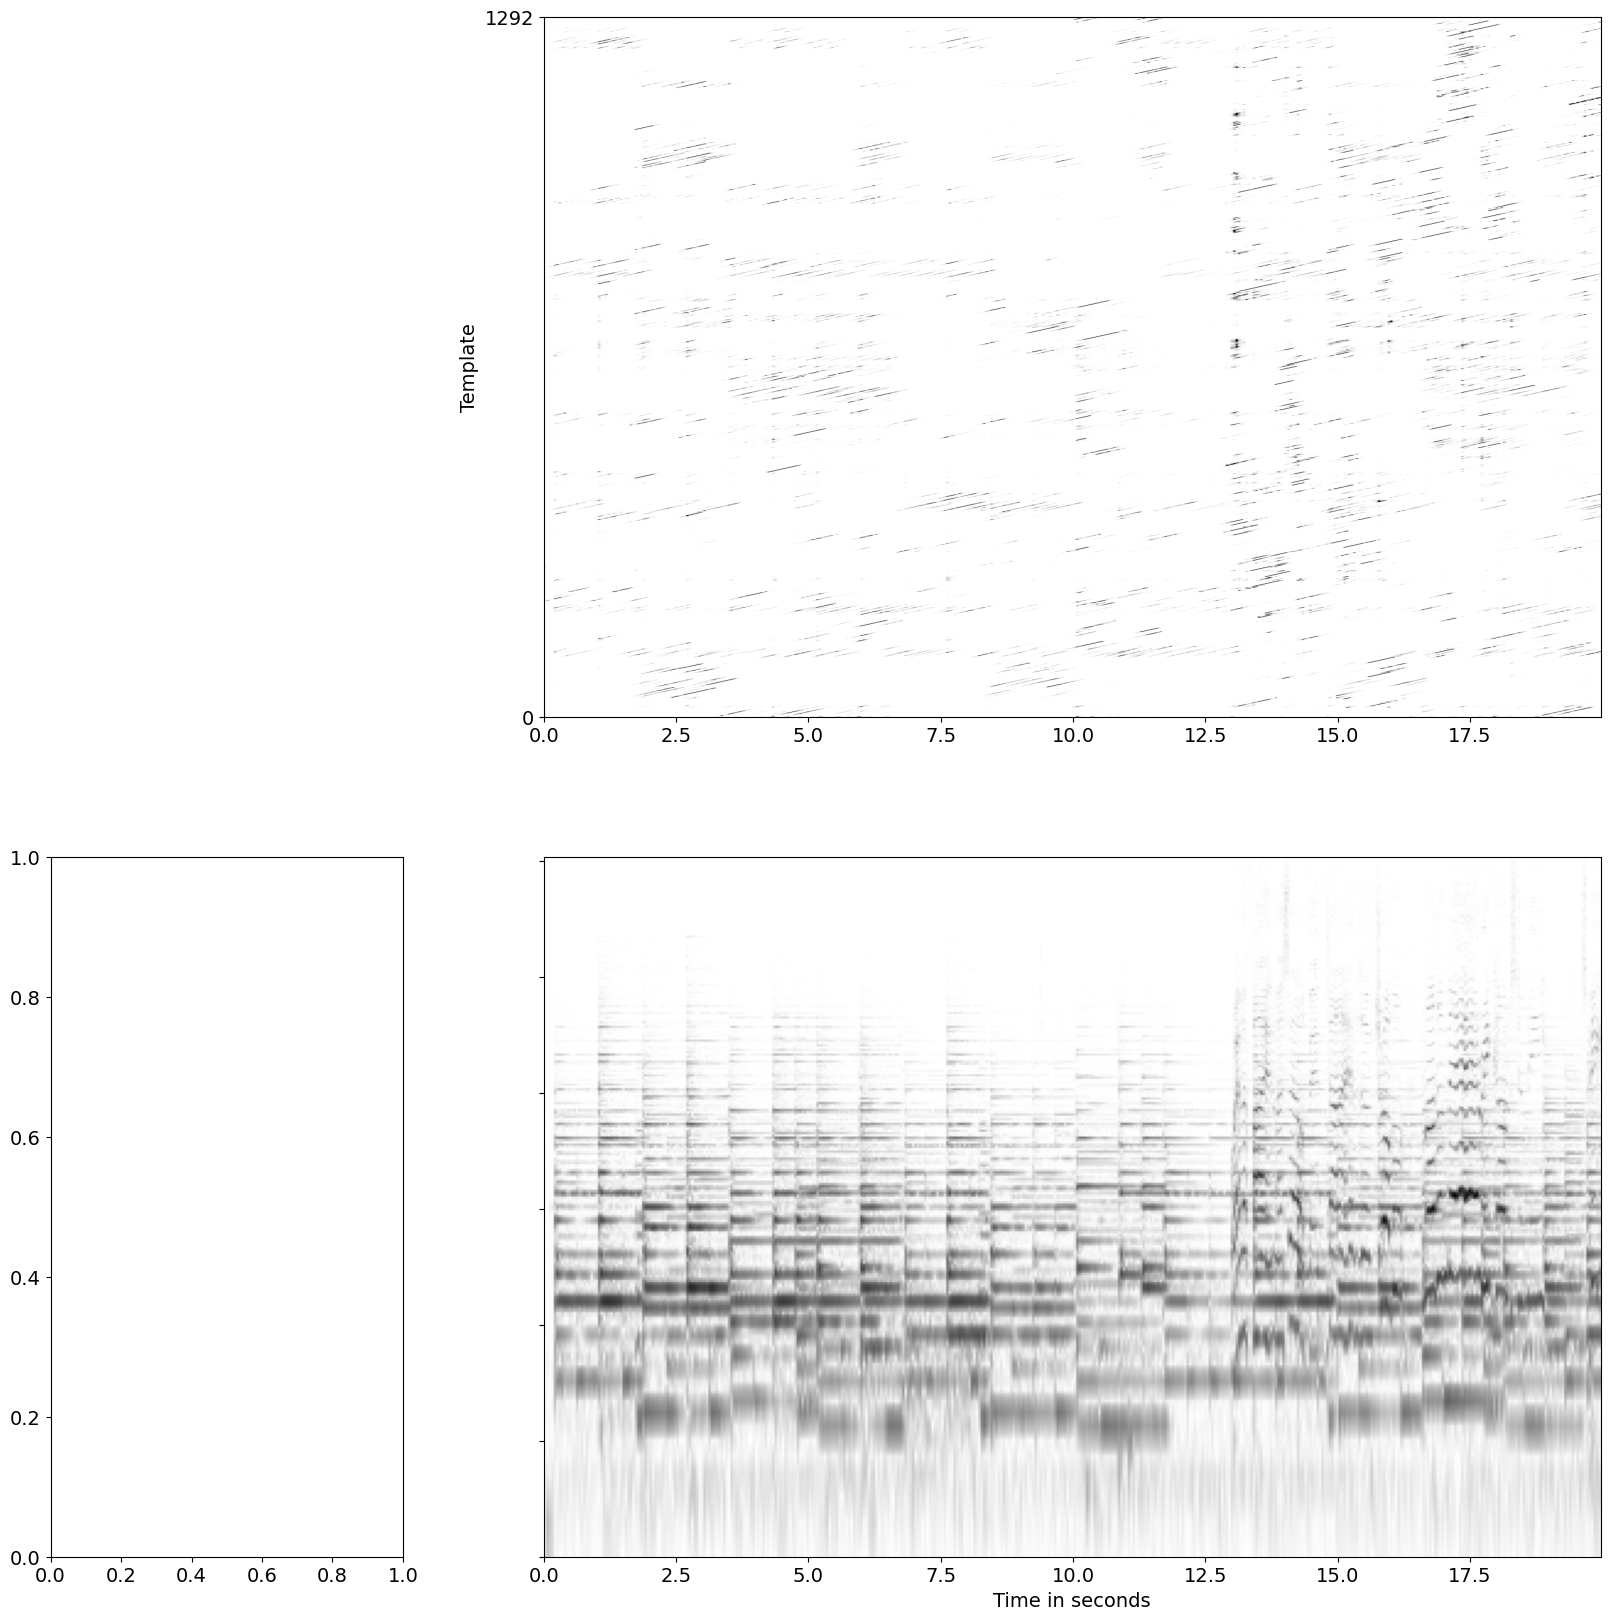

In [8]:
# visualize
fh1, _ = visualize_components_nmf(V=At, W=nmfdiagW, H=nmfdiagH, comp_V=None, freq_res=freq_res, time_res=time_res,
                                  font_size=14)
fh1.savefig(os.path.join(OUT_DIR, 'LetItBee_NMFdiag.png'))

In [ ]:
# resynthesize using Griffin-Lim, 50 iterations by default
_, _, res = griffin_lim(X=contY, block_size=BLOCK_SIZE, hop_size=HOP_SIZE, )

# save result
wav.write(filename=os.path.join(OUT_DIR, 'LetItBee_NMFdiag_with_target_' + filename_target),
          rate=fs,
          data=res*MAX_WAV_VALUE)

#### Let it Be

In [ ]:
# play
ipd.Audio(xt, rate=fs)

#### Buzzing Bees

In [ ]:
# play
ipd.Audio(xs, rate=fs)

#### Let it Bee!

In [ ]:
# play
ipd.Audio(res.T, rate=fs)

#### References
[1] Jonathan Driedger, Thomas Prätzlich, and Meinard Müller<br>
**Let It Bee — Towards NMF-Inspired Audio Mosaicing**<br>
In Proceedings of the International Conference on Music Information Retrieval (ISMIR): 350–356, 2015.

#### If you use the 'NMF toolbox' please refer to 
[2] Patricio López-Serrano, Christian Dittmar, Yiğitcan Özer, and Meinard Müller<br>
**NMF Toolbox: Music Processing Applications of Nonnegative Matrix Factorization**<br>
In Proceedings of the  International Conference on Digital Audio Effects (DAFx), 2019.